# XBeach regular grid

![My Image](xbeach_grid_scheme.png)

Usage demo for the XBeach RegularGrid object (image modified from the [xbeach docs](https://xbeach.readthedocs.io/en/latest/xbeach_manual.html#grid-set-up))

### Requirements

- Clone and install the [main](https://github.com/rom-py/rompy-xbeach) version of rompy-xbeach
- The OSM land plot requires datamesh token to query the OSM land polygon but it is only for demonstration purposes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas
from shapely.geometry import shape

from rompy_xbeach.grid import GeoPoint, RegularGrid

import warnings
warnings.filterwarnings("ignore")

## Grid origin

The origin of the `RegularGrid` is defined using the `GeoPoint` object which holds the
coordinates of the origin `x`, `y` and the `crs` in which the coordinates are defined,
allowing to define the origin in different coordinate systems such as WGS84 or projected
coordinates

In [3]:
ori = GeoPoint(x=115.5875, y=-32.646, crs=4326)
ori

GeoPoint(x=115.5875, y=-32.646, crs='EPSG:4326')

A `GeoPoint` instance can be reprojected

In [4]:
ori_projected = ori.reproject(28350)
ori_projected

GeoPoint(x=367520.0758689749, y=6387075.392325714, crs='EPSG:28350')

In [5]:
ori_projected.reproject(4326)

GeoPoint(x=115.58749999999999, y=-32.646, crs='EPSG:4326')

## Create the grid

The other parameters to construct the grid are similar to the other regular grid objects
in rompy with the inclusion of the field `crs` to define the coordinate reference system of the
xbeach grid. Note the origin coordinates can be prescribed in any known coordinate system

In [6]:
grid = RegularGrid(
    ori=GeoPoint(x=115.5875, y=-32.646, crs="epsg:4326"),
    alfa=344.0,
    dx=10,
    dy=20,
    nx=270,
    ny=305,
    crs="28350",
)
grid

RegularGrid(ori=GeoPoint(x=115.5875, y=-32.646, crs='EPSG:4326'), alfa=344.0, dx=10.0, dy=20.0, nx=270, ny=305, crs='EPSG:28350')

### Grid attributes

#### Some of the attributes of an XBeach grid instance include:

Projected origin coordinates

In [7]:
# The x0, y0 properties are the coordinates of the origin in the grid's crs
# (regardless of the crs defined in Ori)

grid.x0, grid.y0

(367520.0758689749, 6387075.392325714)

Centre of the offshore boundary

In [8]:
grid.offshore

(368358.01343065855, 6389997.627881368)

Centre of the grid

In [9]:
grid.centre

(369650.9104116956, 6389626.895637793)

Grid shape

In [10]:
grid.shape

(305, 270)

Stereographic projection

In [11]:
# A stereographic projection centered on the origin of the grid

grid.projection

<Projected CRS: +proj=stere +ellps=WGS84 +lat_0=-32.646 +lon_0=115 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Stereographic
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Cartopy transform

In [12]:
# The cartopy transform to reference the grid data when plotting

grid.transform

_EPSGProjection(28350)

Grid GeoDataFrame

In [13]:
# A MultiPolygon geometry representing each cell in the grid

grid.gdf

,geometry,Name
0,"MULTIPOLYGON (((367520.076 6387075.392, 367529...","{'grid_type': 'base', 'model_type': 'regular',..."


Coordinates of the different sides

In [14]:
# Tuples of the (x, y) coordinates of each grid side. Uncomment to visualise

# grid.front
# grid.back
# grid.left
# grid.right

## Plot the grid

A plotting method has been defined to allow dealing with different crs and projections.
The offshore boundary and the grid origin are overlaid by default to help positioning
the grid correctly

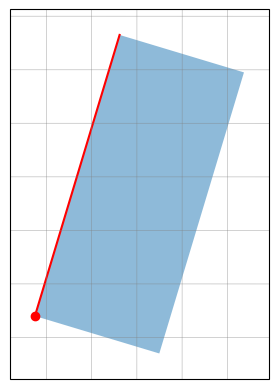

In [15]:
ax = grid.plot()

### Coastlines

The coastlines from the GSHHS database are used which can be slower to plot but are
considerably more detailed than the "10m" resolution version used by default in Cartopy

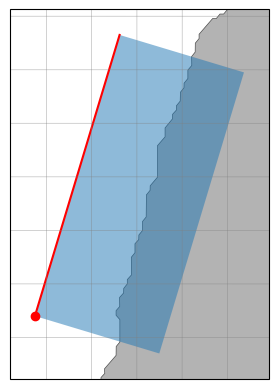

In [16]:
# Coastlines are defined by specifying the GSHHS resolution

ax = grid.plot(scale="f")

### Grid mesh

The grid mesh can be overlaid

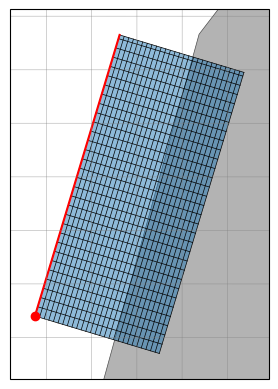

In [17]:
# The full mesh is shown by default but they can be downsampled for better visualisation

ax = grid.plot(scale="i", show_mesh=True, mesh_step=10)

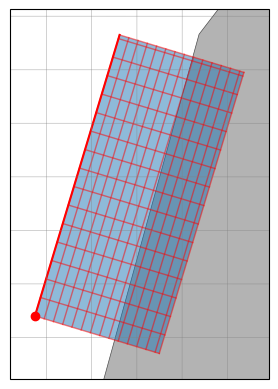

In [18]:
# The appearance of the mesh can be customised using standard matplotlib parameters

ax = grid.plot(
    scale="i",
    show_mesh=True,
    mesh_step=20,
    mesh_kwargs=dict(color="red", alpha=0.5, linewidth=1.0),
)

### Grid boundaries

The offshore boundary is highlighted by default but all boundaries can explicitly overlaid

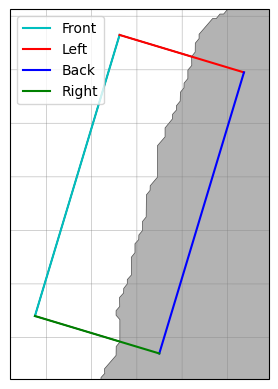

In [19]:
# Plot a transparent grid without the origin and offshore side highlighted
ax = grid.plot(
    scale="f",
    grid_kwargs=dict(facecolor="none"),
    show_origin=False,
    show_offshore=False,
)

# Use the grid attributes to plot each side of the grid
ax.plot(grid.front[0], grid.front[1], "c", transform=grid.transform, label="Front")
ax.plot(grid.left[0], grid.left[1], "r", transform=grid.transform, label="Left")
ax.plot(grid.back[0], grid.back[1], "b", transform=grid.transform, label="Back")
ax.plot(grid.right[0], grid.right[1], "g", transform=grid.transform, label="Right")

l = ax.legend(loc="upper left")

### Projections

Cartopy projections are fully supported

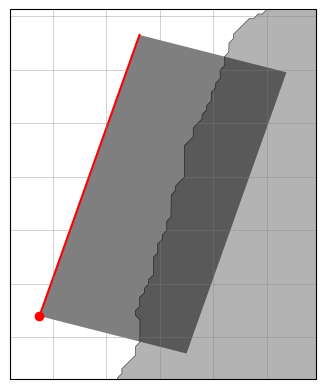

In [20]:
# Use a PlateCarree projection

ax = grid.plot(
    scale="f",
    projection=ccrs.PlateCarree(),
    grid_kwargs=dict(alpha=0.5, facecolor="black", zorder=2),
)

### Land masks

It is possible to use land masks other than the GSHHS ones. In the example below we
are going to define an arbitrary a GeoDataFrame object with some land Polygon to exemplify it

In [21]:
def get_land_feature() -> geopandas.GeoDataFrame:
    """Generate GeoDataFrame with a Polygon feature representing the land."""
    feature = cfeature.NaturalEarthFeature(category="physical", name="land", scale="10m")
    return geopandas.GeoDataFrame(
        geometry=[shape(feature) for feature in feature.geometries()], crs="EPSG:4326"
    ).dissolve()


land = get_land_feature()
land

,geometry
0,"MULTIPOLYGON (((-170.84708 -83.00543, -171.339..."


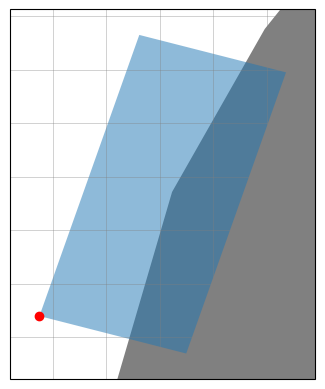

In [22]:
# Plot the grid initially without any land mask
ax = grid.plot(projection=ccrs.PlateCarree(), show_offshore=False)

# Plot the land mask separately
ax = land.plot(ax=ax, transform=ccrs.PlateCarree(), color="gray")

Compare the different GSHHS coastline scales

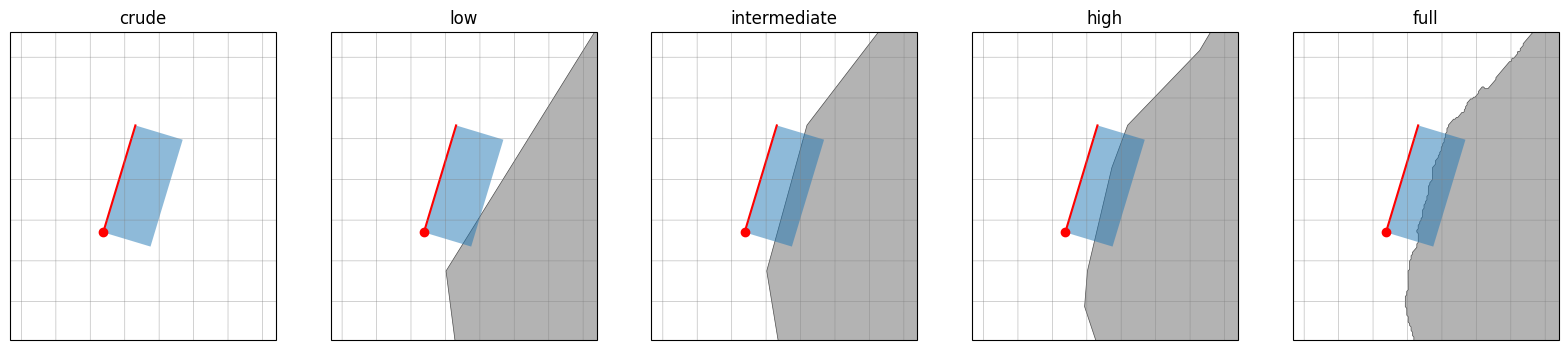

In [23]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4), subplot_kw=dict(projection=grid.projection))

resolution = {
    "crude": "c",
    "low": "l",
    "intermediate": "i",
    "high": "h",
    "full": "f",
}
for ax, (key, value) in zip(axs, resolution.items()):
    grid.plot(ax=ax, scale=value, buffer=5000)
    ax.set_title(key)

Compare the different NaturalEarthFeature scales

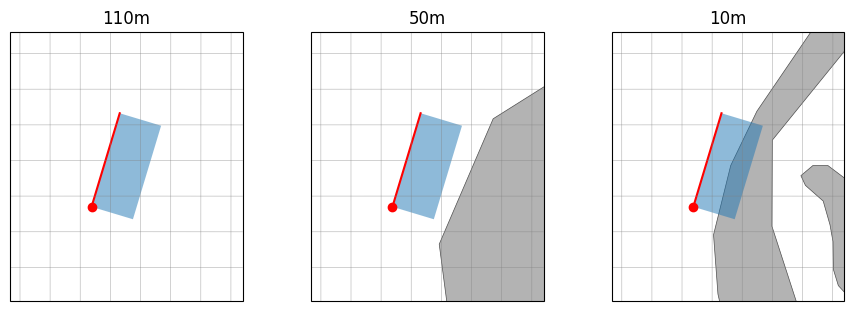

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(11, 3.5), subplot_kw=dict(projection=grid.projection))

for ax, scale in zip(axs, ["110m", "50m", "10m"]):
    ax.add_feature(cfeature.LAND.with_scale(scale), facecolor="0.7", edgecolor="0.3", linewidth=0.5)
    grid.plot(ax=ax, scale=None, buffer=5000)
    ax.set_title(scale)

## Expand the grid

The grid can be expanded which is useful when extending the offshore and lateral boundaries

In [25]:
# Individual sides are expanded by a specified number of cells

grid_extended = grid.expand(left=5, right=5, front=30)

print(grid)
print(grid_extended)

RegularGrid(ori=GeoPoint(x=115.5875, y=-32.646, crs='EPSG:4326'), alfa=344.0, dx=10.0, dy=20.0, nx=270, ny=305, crs='EPSG:28350')
RegularGrid(ori=GeoPoint(x=115.58413040314187, y=-32.64608321400174, crs='EPSG:4326'), alfa=344.0, dx=10.0, dy=20.0, nx=300, ny=315, crs='EPSG:28350')


<GeoAxes: >

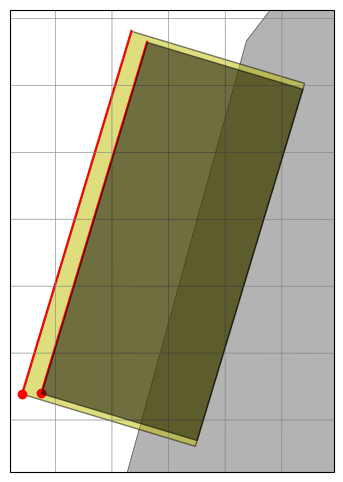

In [26]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection=grid.projection))

grid_extended.plot(ax=ax, scale="i", grid_kwargs=dict(facecolor="y", edgecolor="k", alpha=0.5, zorder=2))
grid.plot(ax=ax, grid_kwargs=dict(facecolor="k", edgecolor="k", alpha=0.5, zorder=3))

## Save the grid

A custom method is provided to save the grid as a MultiPolygon GeoDataFrame object
which can be visualised on GIS software

In [27]:
grid.to_file("grid.kml", driver="KML")

INFO:pyogrio._io:Created 1 records


Open and visualise it on GGE

![My Image](grid_on_imagery.png)

Alternatively, a GeoDataFrame of the grid boundaries can be defined and saved to file (which can be useful if the grid is too large)

In [28]:
import geopandas as gpd

gdf = gpd.GeoSeries(grid.boundary(), crs=grid.crs)
gdf.to_file("grid_boundaries.kml", driver="KML")

INFO:pyogrio._io:Created 1 records


### Recreate the grid

The (full) grid file also stores some grid metadata to allow recreating a grid object (making it easy to share)

<GeoAxes: >

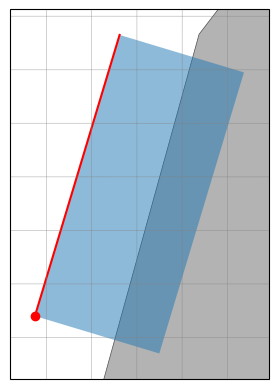

In [29]:
grid2 = RegularGrid.from_file("grid.kml")
grid2.plot(scale="i")